In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import pandas as pd
import numpy as np
import datetime
import pytz
import os
import glob
import sys
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa import stattools
from scipy.signal import savgol_filter

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

In [9]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_context('notebook', font_scale=1.5,rc={"lines.linewidth": 2.5})
sns.set_palette(sns.color_palette("Paired"))

### Setup and Load Data

In [10]:
#Please change to the location of the git_hub reporsitory
os.chdir('/Users/nehrend/work/algo_trading_book/')

In [11]:
trade = pd.read_pickle('./datasets/trade_data.gzip').sort_index()

In [12]:
amzn = trade.loc[pd.IndexSlice['AMZN','2016-10-03'],['Size','Price']]

In [297]:
amzn_profile = pd.read_csv('./datasets/amzn_profile.csv')
amzn_profile = amzn_profile.assign(time = pd.to_timedelta(amzn_profile.time)).set_index('time')

Generate minute bars and calculate vwap for the bin

In [14]:
def vwap(df):
    d = {}
    d['vwap'] = (df['Size']*df['Price']).sum()/df['Size'].sum()
    return pd.Series(data = d)

min_vwap = amzn.reset_index().groupby(pd.Grouper(key='Timestamp',freq='1MIN')).apply(vwap)

### VWAP Schedule

In [15]:
order = 100000
vwap = order*amzn_profile.rename(columns={'profile':'exec_shares'})
vwap = vwap.assign(exec_price = min_vwap.vwap.values,exec_shares = np.round(vwap.exec_shares/100)*100 )

Adjust the order after rounding to ensure full order is traded

In [16]:
e_lots = int((order - vwap.exec_shares.sum())/100)
vwap.iloc[np.random.choice(range(390),np.abs(e_lots)),0] += np.sign(e_lots)*100

In [17]:
def bin_30_f(df):
    d = {}
    d['exec_shares'] = df['exec_shares'].sum()
    d['exec_price'] = (df['exec_shares']*df['exec_price']).sum()/df['exec_shares'].sum()
    return pd.Series(data = d)
bin_30 = vwap.reset_index().groupby(pd.Grouper(key='time', freq='30MIN')).apply(bin_30_f)

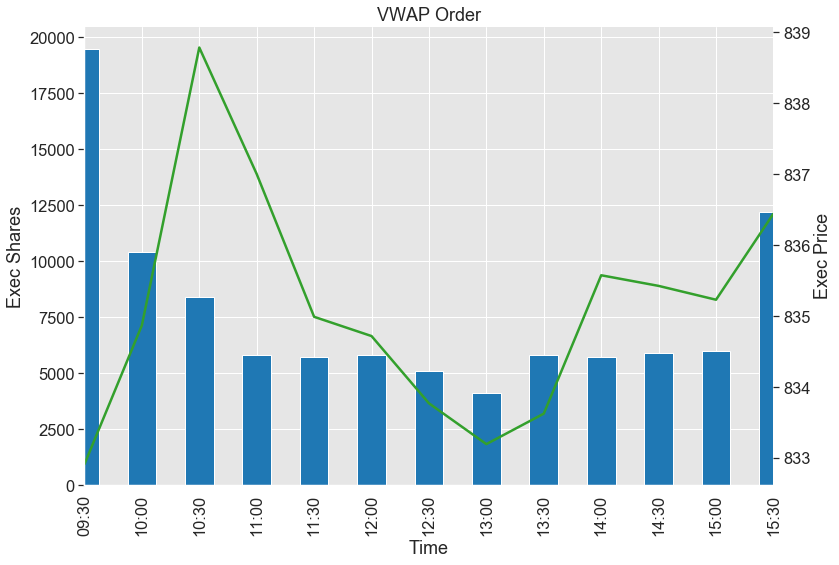

In [19]:
bin_30_w = vwap.reset_index().groupby(pd.Grouper(key='time', freq='30MIN')).apply(bin_30_f).reset_index()
bin_30_p = bin_30_w.assign(time_str = pd.to_datetime(bin_30_w.time).dt.strftime("%H:%M")).reset_index()
fix, ax = plt.subplots(figsize=(12,8))
_ = bin_30_p.plot.bar(x='time_str',y='exec_shares',ax =ax,color='C1',legend=None)
_ = ax.set_xlabel('Time')
_ = ax.set_ylabel('Exec Shares')
ax2 = ax.twinx()
_ = bin_30_p.plot(x='time_str',y='exec_price',color='C3',ax=ax2,legend=None)
_ = ax2.set_ylabel('Exec Price')
_ = ax2.grid(None)
sns.despine()
plt.tight_layout()
plt.savefig('./book/chapters/chapter_exec_models/figures/vwap.png', format='png', dpi=300)
plt.title('VWAP Order')
plt.show()

### TWAP Schedule

In [20]:
order = 100000
twap = amzn_profile.copy().assign(profile=np.ones(390)/390)
twap = order*twap.rename(columns={'profile':'exec_shares'}).assign()
twap = twap.assign(exec_price= min_vwap.vwap.values,exec_shares = np.round(twap.exec_shares/100)*100 )

In [21]:
e_lots = int((order - twap.exec_shares.sum())/100)
twap.iloc[np.random.choice(range(390),np.abs(e_lots)),0] += np.sign(e_lots)*100

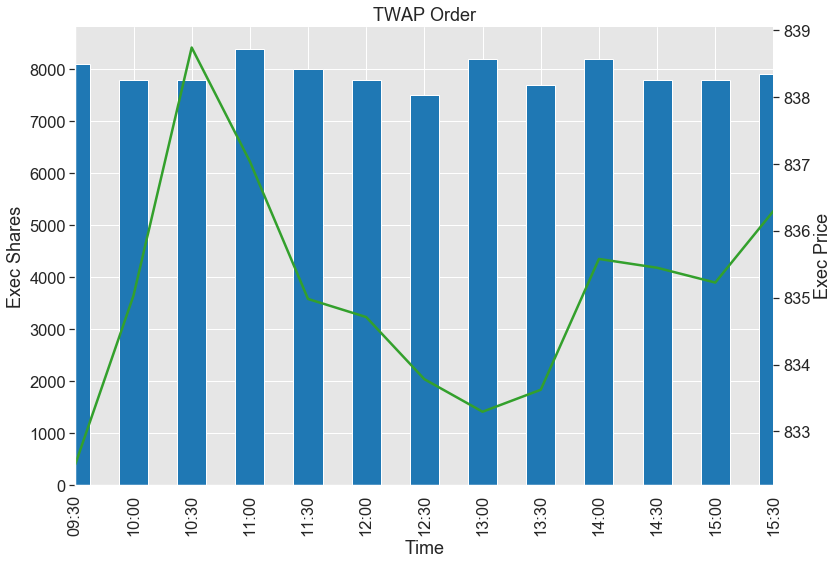

In [23]:
bin_30_t = twap.reset_index().groupby(pd.Grouper(key='time', freq='30MIN')).apply(bin_30_f).reset_index()
bin_30_p = bin_30_t.assign(time_str = pd.to_datetime(bin_30_t.time).dt.strftime("%H:%M"))
fix, ax = plt.subplots(figsize=(12,8))
_ = bin_30_p.plot.bar(x='time_str',y='exec_shares',ax =ax,color='C1',legend=None)
_ = ax.set_xlabel('Time')
_ = ax.set_ylabel('Exec Shares')
ax2 = ax.twinx()
_ = bin_30_p.plot(x='time_str',y='exec_price',color='C3',ax=ax2,legend=None)
_ = ax2.set_ylabel('Exec Price')
_ = ax2.grid(None)
sns.despine()
plt.tight_layout()
plt.savefig('./book/chapters/chapter_exec_models/figures/twap.png', format='png', dpi=300)
plt.title('TWAP Order')
plt.show()

### POV Schedule

In [24]:
order = 100000
pov_rate = 0.05

def pov_calc(df, pov_rate):
    d = {}
    d['exec_shares'] = np.round(0.01*pov_rate*df['Size'].sum())*100
    
    d['exec_price'] = (df['Size']*df['Price']).sum()/df['Size'].sum()
    return pd.Series(data = d)
pov = amzn.reset_index().groupby(pd.Grouper(key='Timestamp',freq='1MIN')).apply(pov_calc, pov_rate=pov_rate)

In [25]:
pov.loc[pov.exec_shares.cumsum() > order,:] = 0
pov.index = amzn_profile.index.copy()

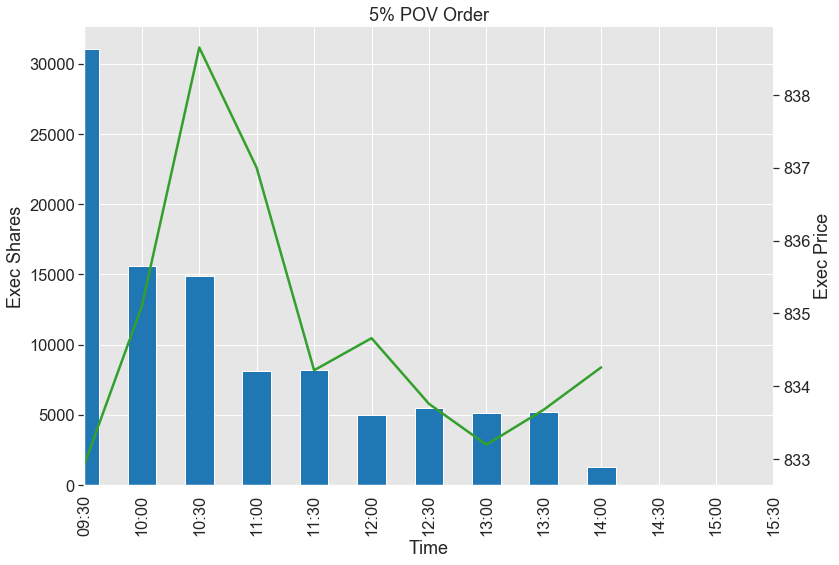

In [26]:
bin_30_pov = pov.reset_index().groupby(pd.Grouper(key='time', freq='30MIN')).apply(bin_30_f).reset_index()
bin_30_p = bin_30_pov.reset_index().assign(time_str = pd.to_datetime(bin_30_pov.time).dt.strftime("%H:%M"))
fix, ax = plt.subplots(figsize=(12,8))
_ = bin_30_p.plot.bar(x='time_str',y='exec_shares',ax =ax,color='C1',legend=None)
_ = ax.set_xlabel('Time')
_ = ax.set_ylabel('Exec Shares')
ax2 = ax.twinx()
_ = bin_30_p.plot(x='time_str',y='exec_price',color='C3',ax=ax2,legend=None)
_ = ax2.set_ylabel('Exec Price')
_ = ax2.grid(None)
sns.despine()
plt.tight_layout()
plt.savefig('./book/chapters/chapter_exec_models/figures/pov.png', format='png', dpi=300)
plt.title('5% POV Order')
plt.show()

### Close

This is only a crude semplification of what a Close strategy would do and it's for visualization purpouses only. 

For a real implementation one would first determine the quantity to trade into the close after at what rate they want to trade into the close to fulfill the remainder. Some implementation use a "Reverse IS" approach with an optimized schedule that trades off cost for the risk of missing the benchamrk.

In [320]:
order = 100000
close = amzn_profile.copy().rename(columns={'profile':'exec_shares'})
close.iloc[:210,0] = 0
close.iloc[210:,0] = (close.iloc[210:,0]/close.iloc[210:,0].sum())*order
close = close.assign(exec_price = min_vwap.vwap.values,exec_shares = np.round(close.exec_shares/100)*100 )

In [322]:
e_lots = int((order - close.exec_shares.sum())/100)
close.iloc[np.random.choice(range(210,390),np.abs(e_lots)),0] += np.sign(e_lots)*100

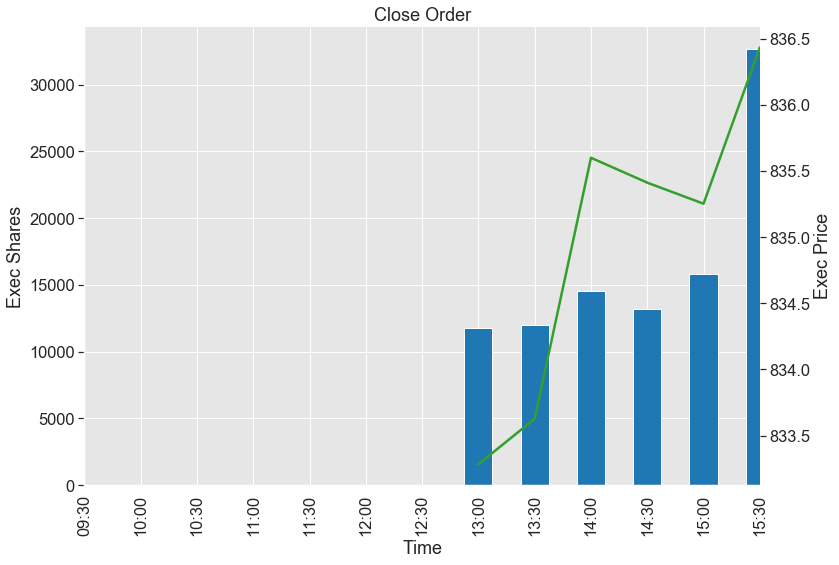

In [324]:
bin_30_c = close.reset_index().groupby(pd.Grouper(key='time', freq='30MIN')).apply(bin_30_f).reset_index()
bin_30_p = bin_30_c.reset_index().assign(time_str = pd.to_datetime(bin_30_c.time).dt.strftime("%H:%M"))
fix, ax = plt.subplots(figsize=(12,8))
_ = bin_30_p.plot.bar(x='time_str',y='exec_shares',ax =ax,color='C1',legend=None)
_ = ax.set_xlabel('Time')
_ = ax.set_ylabel('Exec Shares')
ax2 = ax.twinx()
_ = bin_30_p.plot(x='time_str',y='exec_price',color='C3',ax=ax2,legend=None)
_ = ax2.set_ylabel('Exec Price')
_ = ax2.grid(None)
sns.despine()
plt.tight_layout()
plt.savefig('./book/chapters/chapter_exec_models/figures/close.png', format='png', dpi=300)
plt.title('Close Order')
plt.show()

### Almgren Chris Implementation Shortfall Schedule

To avoid recreating the same work others have already done we leverage the excellent implementation ébastien David, Arthur Bagourd, Mounah Bizri
https://github.com/Arthurim/ElectronicMarkets

For convenience we copied the code in a python script to use here

In [71]:
sys.path.append('./notebooks')
import almgren_chriss

Setup the various Parameters needed for the Market Impact Model and all other order charateristics needed for the solution

In [253]:
# MI Params
_tau = 0.5
_gamma = 2.5*10**(-7)
_eta = 2.5*10**(-6)
_eps = 0.0625

n_bins = 390
order = 100000
adv = 1000000
sigma = 0.3*np.ones(n_bins)
ap = amzn.Price[0]
v_prof = amzn_profile.profile.values
risk_aversions = [2*10e-8,2*10e-9,7*10e-10]

ag_solutions = []

for ra in risk_aversions:
    ag_solution = almgren_chriss.efficient_frontier(X=order, risk=ra, nb_T=n_bins, s0=ap ,
                                                v = v_prof,sigma=sigma, benchmark='IS',tau=_tau, 
                                                gamma=_gamma,eta=_eta,eps=_eps,plot=False)
    ag_solutions.append(ag_solution)



In [254]:
def generate_is_schedule(ag_solution):
    sol = np.array(ag_solution[0])[:-1]
    sol[sol<100]=0
    imp_s = amzn_profile.copy().assign(profile=sol).rename(columns={'profile':'exec_shares'})
    imp_s = imp_s.assign(exec_price = min_vwap.vwap.values, exec_shares = (0.01*imp_s.exec_shares.diff(periods=-1)).round(0)*100)
    end_idx = np.where(imp_s.exec_shares == 0)[0]
    if end_idx.shape[0] == 0:
        end_idx = 390
    else:
        end_idx = end_idx[0]
        imp_s.iloc[end_idx:,0]=0
    e_lots = int((order - imp_s.exec_shares.sum())/100)
    slots = np.random.choice(range(end_idx),np.abs(e_lots))
    imp_s.iloc[slots,0] += np.sign(e_lots)*100
    bin_30_is = imp_s.reset_index().groupby(pd.Grouper(key='time', freq='30MIN')).apply(bin_30_f).reset_index()
    bin_30_p = bin_30_is.reset_index().assign(time_str = pd.to_datetime(bin_30_is.time).dt.strftime("%H:%M"))
    return bin_30_p
    #return imp_s

In [255]:
imp_schedules = []
for sch in ag_solutions:
    imp_schedules.append(generate_is_schedule(sch))

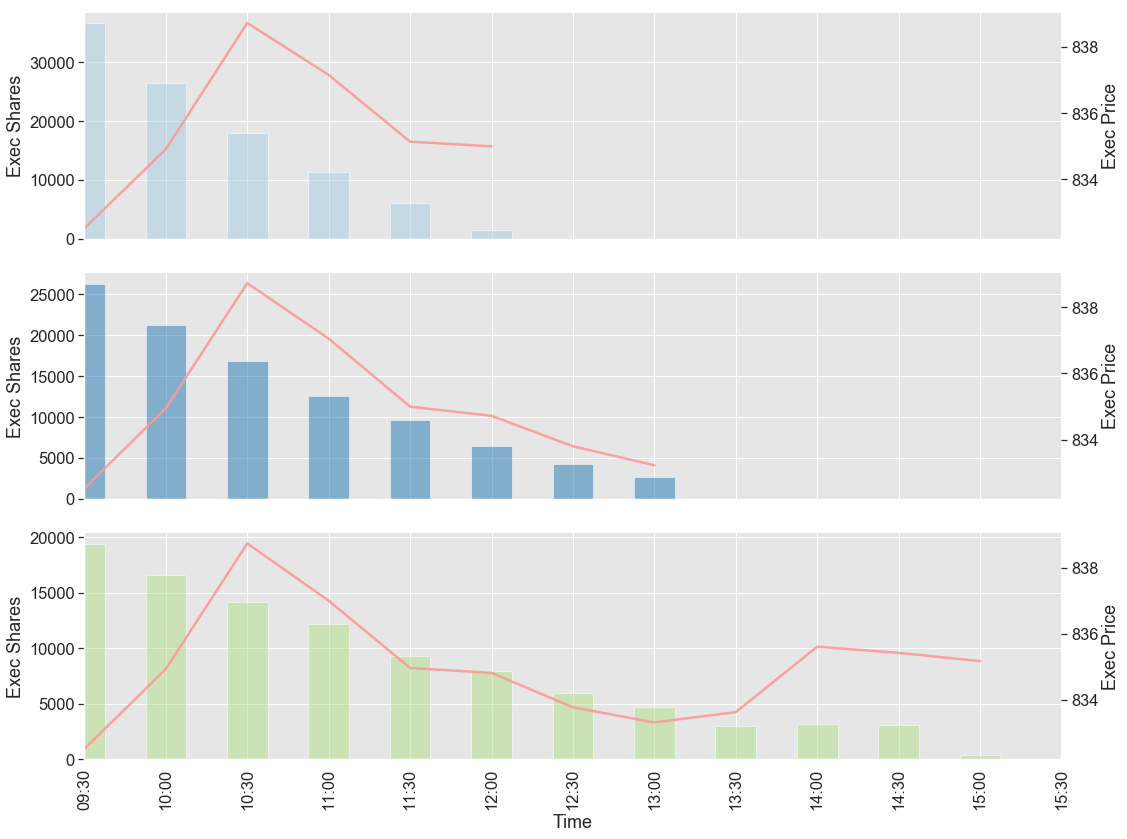

In [256]:
fix, ax = plt.subplots(3,1,figsize=(16,12),sharex=True)

ax2 = [axi.twinx() for axi in ax]

c1= ['C0','C1',"C2"]
c2= ['C3','C4',"C5"]
for i, imp in enumerate(imp_schedules):
    _ = imp.plot.bar(x='time_str',y='exec_shares',ax =ax[i],color=c1[i],alpha=0.5,legend=None,)
    _ = imp.plot(x='time_str',y='exec_price',ax=ax2[i],color='C4',alpha=0.9,legend=None)
    _ = ax[i].set_xlabel('Time')
    _ = ax[i].set_ylabel('Exec Shares')
    _ = ax2[i].set_ylabel('Exec Price')
    _ = ax2[i].grid(None)
sns.despine()
plt.tight_layout()
plt.savefig('./book/chapters/chapter_exec_models/figures/is.png', format='png', dpi=300)
plt.show()

In [400]:
schedule = amzn_profile.copy().cumsum()
upper_band = schedule + 0.05
lower_band = schedule - 0.05
ub_taper = np.concatenate((np.linspace(0,1,30),np.ones(360)))

lb_taper = np.concatenate((np.linspace(0,1,30),np.ones(330),np.linspace(1,0,30)))
ub = upper_band.profile*ub_taper + (1 - ub_taper)*schedule.profile
ub[ub>=1]=1

lb = lower_band.profile*lb_taper + (1 - lb_taper)*schedule.profile


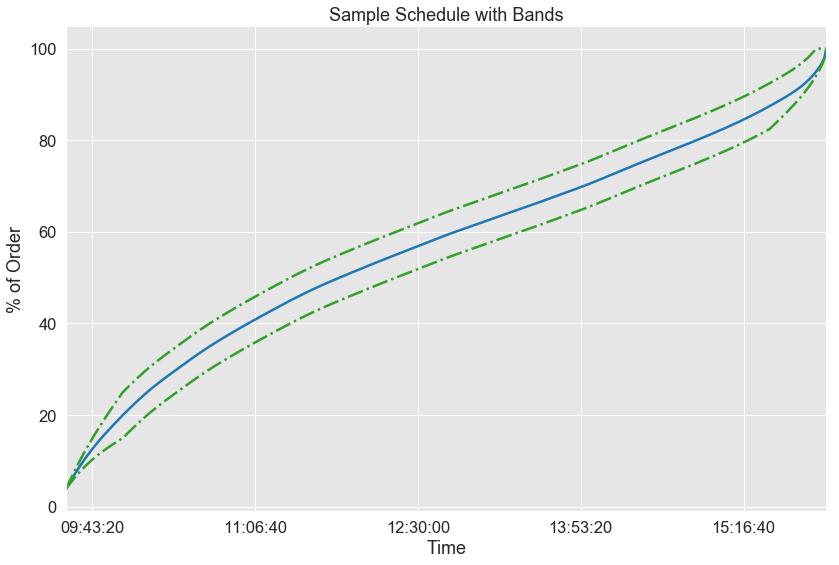

In [559]:
fig, ax = plt.subplots(figsize=(12,8))
_ = (100*schedule).plot(ax = ax, color='C1',legend=None)
_ = (100*ub).plot(ax = ax, color='C3',linestyle='-.',legend=None)
_ = (100*lb).plot(ax = ax, color='C3',linestyle='-.',legend=None)
_ = plt.xlabel('Time')
_ = plt.ylabel('% of Order')
sns.despine()
plt.tight_layout()
plt.savefig('./book/chapters/chapter_exec_models/figures/schedule.png', format='png', dpi=300)
plt.title('Sample Schedule with Bands')
plt.show()

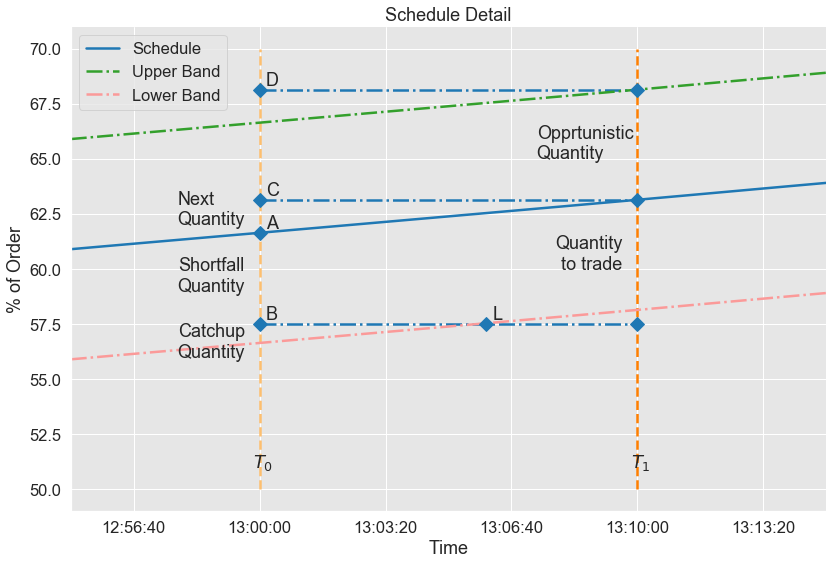

In [596]:
p_now = 57.5
p_target = schedule.profile['13:00:00']*100
p_next = schedule.profile['13:10:00']*100
p_opp = ub['13:10:00']*100

t_now = 46800000000000
t_next= 47400000000000
t_late = lb.iloc[np.where(lb*100>=p_now)[0][0]:,].index[0].value

fig, ax = plt.subplots(figsize=(12,8))
_ = (100*schedule).loc['12:55:00':'13:15:00'].plot(ax = ax, color='C1',legend=None)
_ = (100*ub).loc['12:55:00':'13:15:00'].plot(ax = ax, color='C3',linestyle='-.',legend=None)
_ = (100*lb).loc['12:55:00':'13:15:00'].plot(ax = ax, color='C4',linestyle='-.',legend=None)
_ = plt.vlines(t_now,50,70,color='C6',linestyle='--')
_ = plt.vlines(t_next,50,70,color='C7',linestyle='--')


_ = plt.plot(t_now,p_target,'D',color='C1',markersize=10)
_ = plt.annotate("A",(t_now+1e10,p_target+0.2))

_ = plt.plot(t_now,p_now,'D',color='C1',markersize=10)
_ = plt.annotate("B",(t_now+1e10,p_now+0.2))



_ = plt.plot(t_now,p_next,'D',color='C1',markersize=10)
_ = plt.plot(t_next,p_next,'D',color='C1',markersize=10)
_ = plt.plot(t_next,p_now,'D',color='C1',markersize=10)

_ = plt.plot(t_late,p_now,'D',color='C1',markersize=10)

_ = plt.annotate("L",(t_late+1e10,p_now+0.2))

_ = plt.plot(t_next,p_opp,'D',color='C1',markersize=10)
_ = plt.plot(t_now,p_opp,'D',color='C1',markersize=10)
_ = plt.annotate("D",(t_now+1e10,p_opp+0.2))
_ = plt.hlines(p_opp,t_now,t_next,color='C1',linestyle='-.')

_ = plt.hlines(p_now,t_now,t_next,color='C1',linestyle='-.')
_ = plt.annotate("C",(t_now+1e10,p_next+0.2))

_ = plt.hlines(p_next,t_now,t_next,color='C1',linestyle='-.')

_ = plt.annotate('Opprtunistic\nQuantity',(t_next - 1.6e11,65))
_ = plt.annotate('Quantity\n to trade',(t_next - 1.3e11,60))
_ = plt.annotate('Shortfall\nQuantity',(t_now - 1.3e11,59))
_ = plt.annotate('Next\nQuantity',(t_now - 1.3e11,62))
_ = plt.annotate('Catchup\nQuantity',(t_now - 1.3e11,56))
_ = plt.annotate('$T_0$',(t_now - 1e10,51))
_ = plt.annotate('$T_1$',(t_next - 1e10,51))

_ = plt.xlabel('Time')
_ = plt.ylabel('% of Order')
plt.legend(['Schedule','Upper Band','Lower Band'])
sns.despine()
plt.tight_layout()
plt.savefig('./book/chapters/chapter_exec_models/figures/schedule_details.png', format='png', dpi=300)
plt.title('Schedule Detail')
plt.show()

In [500]:
schedule.loc['13:06:00':'13:10:00'].index.values

array([47160000000000, 47220000000000, 47280000000000, 47340000000000,
       47400000000000], dtype='timedelta64[ns]')

47160000000000

In [468]:
p1

0.6014760564880499